<!-- Autogenerated by `scripts/make_examples.py` -->
<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/voxel51/fiftyone-examples/blob/master/examples/Integrate_nuscenes.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791629-6e618700-5769-11eb-857f-d176b37d2496.png" height="32" width="32">
            Try in Google Colab
        </a>
    </td>
    <td>
        <a target="_blank" href="https://nbviewer.jupyter.org/github/voxel51/fiftyone-examples/blob/master/examples/Integrate_nuscenes.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791634-6efa1d80-5769-11eb-8a4c-71d6cb53ccf0.png" height="32" width="32">
            Share via nbviewer
        </a>
    </td>
    <td>
        <a target="_blank" href="https://github.com/voxel51/fiftyone-examples/blob/master/examples/Integrate_nuscenes.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791633-6efa1d80-5769-11eb-8ee3-4b2123fe4b66.png" height="32" width="32">
            View on GitHub
        </a>
    </td>
    <td>
        <a href="https://github.com/voxel51/fiftyone-examples/raw/master/examples/Integrate_nuscenes.ipynb" download>
            <img src="https://user-images.githubusercontent.com/25985824/104792428-60f9cc00-576c-11eb-95a4-5709d803023a.png" height="32" width="32">
            Download notebook
        </a>
    </td>
</table>


In [7]:
!fiftyone datasets delete nuscenes_final

Dataset 'nuscenes_final' deleted


In [8]:
from nuscenes.nuscenes import NuScenes
import fiftyone as fo

nusc = NuScenes(version='v1.0-mini', dataroot='/data/sets/nuscenes', verbose=True)

dataset = fo.Dataset("nuscenes_final", overwrite=True)
dataset.add_group_field("group", default="CAM_FRONT")

Loading NuScenes tables for version v1.0-mini...
Loading nuScenes-lidarseg...
Loading nuScenes-panoptic...
32 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
404 lidarseg,
404 panoptic,
Done loading in 0.201 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [9]:
from nuscenes.utils.data_io import load_bin_file
from nuscenes.utils.color_map import get_colormap
from nuscenes.lidarseg.lidarseg_utils import paint_points_label
from nuscenes.utils.data_classes import LidarPointCloud
import open3d as o3d
import os

def load_lidar(lidar_token):

    #Grab and Generate Colormaps
    gt_from = "lidarseg"
    lidarseg_filename = "/data/sets/nuscenes/" + nusc.get(gt_from, lidar_token)['filename']
    colormap = get_colormap()
    name2index = nusc.lidarseg_name2idx_mapping

    coloring = paint_points_label(lidarseg_filename,None,name2index, colormap=colormap)
    filepath = "/data/sets/nuscenes/" + nusc.get("sample_data", lidar_token)['filename']
    root, extension = os.path.splitext(filepath)

    #Load Point Cloud
    cloud = LidarPointCloud.from_file(filepath)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(cloud.points[:3,:].T)
    colors = coloring[:,:3]
    colors.max()
    pcd.colors = o3d.utility.Vector3dVector(colors)

    #Save back Point Cloud
    o3d.io.write_point_cloud(root, pcd)

    return root

In [10]:
from nuscenes.utils.geometry_utils import  BoxVisibility
from nuscenes.scripts.export_poses import derive_latlon

def lidar_sample(group, filepath, sensor, lidar_token, scene):
    data_path, boxes, camera_intrinsic = nusc.get_sample_data(lidar_token, box_vis_level=BoxVisibility.NONE,)
    sample = fo.Sample(filepath=filepath, group=group.element(sensor))
    data = nusc.get('sample_data', lidar_token)
    log = nusc.get('log', scene["log_token"])
    location = log["location"]
    ego = nusc.get('ego_pose', data["ego_pose_token"])
    ego_list = [ego]

    latlon = derive_latlon(location,ego_list)
    lat = latlon[0]["latitude"]
    lon = latlon[0]["longitude"]
    sample["location"] = fo.GeoLocation(
        point = [lon,lat]
    )
    detections = []
    for box in boxes:
                    
        x, y, z = box.orientation.yaw_pitch_roll
        w, l, h = box.wlh.tolist()

        detection = fo.Detection(
                label=box.name,
                location=box.center.tolist(),
                rotation=[z, y, x],
                dimensions=[l,w,h]
                )
        detections.append(detection)
    sample["ground_truth"] = fo.Detections(detections=detections)
    return sample

In [11]:
from nuscenes.utils.geometry_utils import box_in_image, view_points
import numpy as np

def camera_sample(group, filepath, sensor, token, scene):
    sample = fo.Sample(filepath=filepath, group=group.element(sensor))
    data_path, boxes, camera_intrinsic = nusc.get_sample_data(token, box_vis_level=BoxVisibility.NONE,)
    image = Image.open(data_path)
    width, height = image.size
    shape = (height,width)
    polylines = []
    log = nusc.get('log', scene["log_token"])
    location = log["location"]
    ego = nusc.get('ego_pose', data["ego_pose_token"])
    ego_list = [ego]

    latlon = derive_latlon(location,ego_list)
    lat = latlon[0]["latitude"]
    lon = latlon[0]["longitude"]
    sample["location"] = fo.GeoLocation(
        point = [lon,lat]
    )
    for box in boxes:
        if box_in_image(box,camera_intrinsic,shape,vis_level=BoxVisibility.ALL):
            c = np.array(nusc.colormap[box.name]) / 255.0
            #print(box.name)
            corners = view_points(box.corners(), camera_intrinsic, normalize=True)[:2, :]
            front = [(corners[0][0]/width,corners[1][0]/height),
                    (corners[0][1]/width,corners[1][1]/height),
                    (corners[0][2]/width,corners[1][2]/height),
                    (corners[0][3]/width,corners[1][3]/height),]
            back =  [(corners[0][4]/width,corners[1][4]/height),
                    (corners[0][5]/width,corners[1][5]/height),
                    (corners[0][6]/width,corners[1][6]/height),
                    (corners[0][7]/width,corners[1][7]/height),]
            #print(corners.shape)
            polylines.append(fo.Polyline.from_cuboid(front + back, label=box.name))
    sample["cuboids"] = fo.Polylines(polylines=polylines)
    return sample

 100% |███████████████| 4728/4728 [12.6s elapsed, 0s remaining, 588.9 samples/s]      



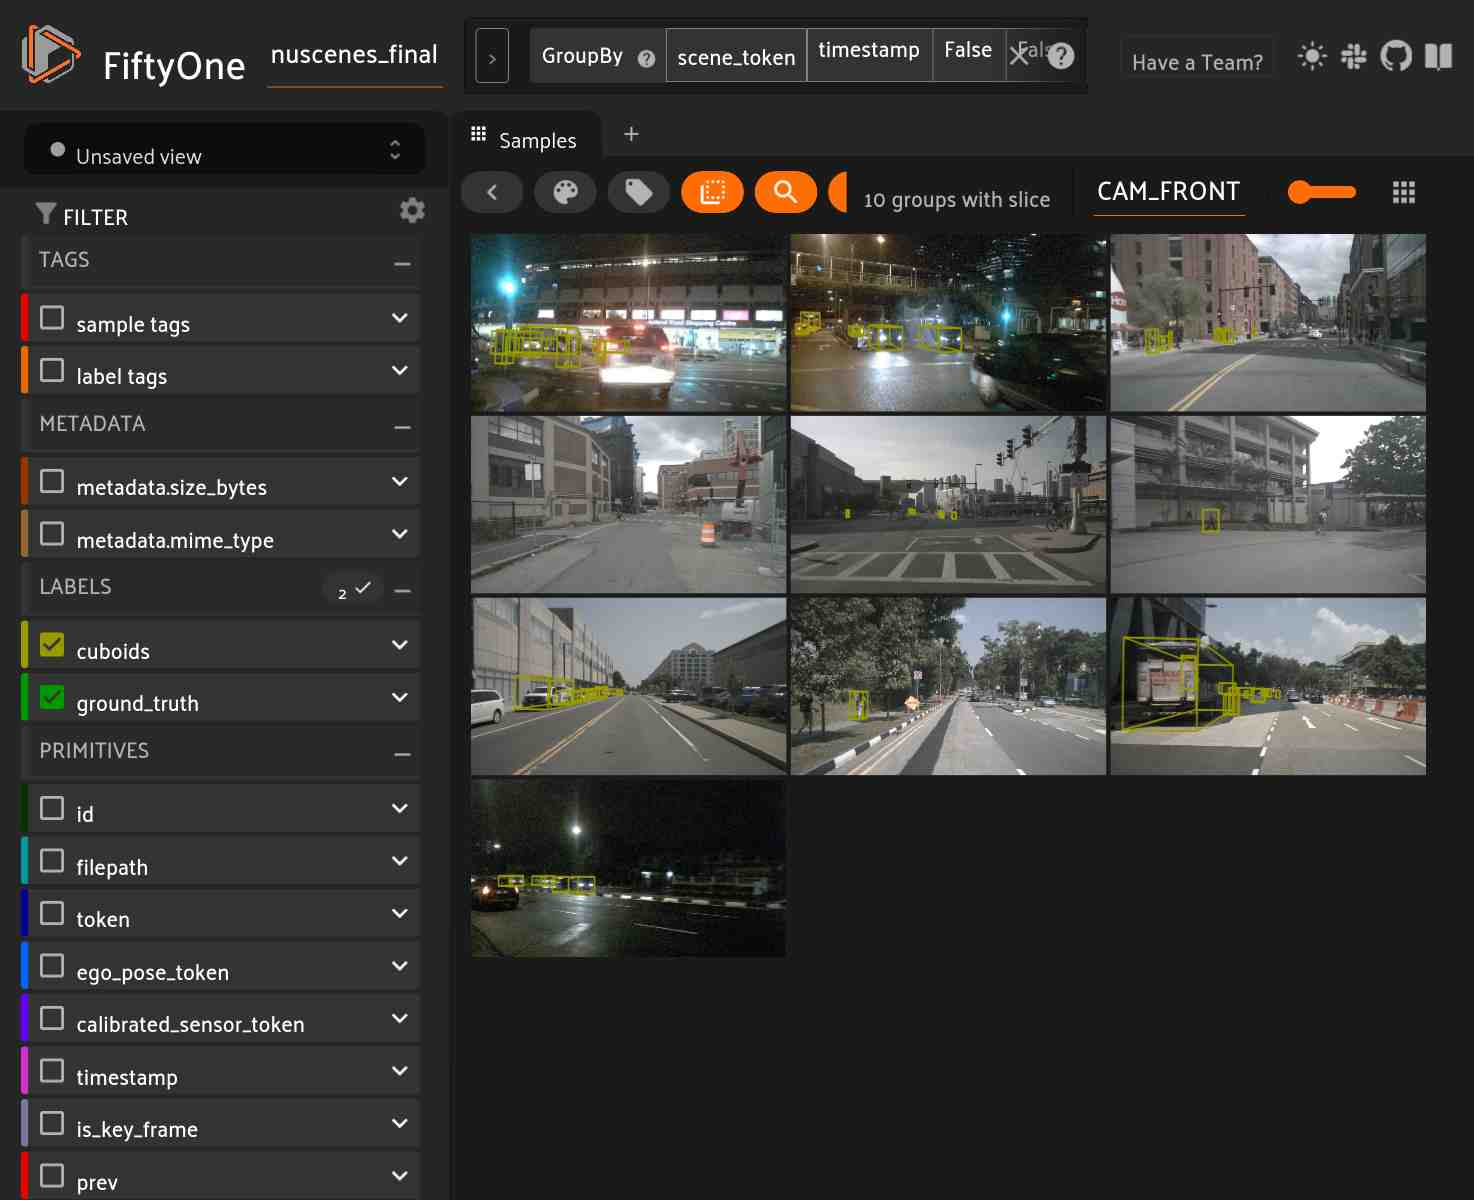


Could not connect session, trying again in 10 seconds



In [12]:
from PIL import Image
from nuscenes.utils.geometry_utils import view_points, BoxVisibility, box_in_image
import numpy as np
import os

groups = ["CAM_FRONT", "CAM_FRONT_RIGHT", "CAM_BACK_RIGHT", "CAM_BACK",
           "CAM_BACK_LEFT", "CAM_FRONT_LEFT","LIDAR_TOP", "RADAR_FRONT",
           "RADAR_FRONT_LEFT", "RADAR_FRONT_RIGHT", "RADAR_BACK_LEFT", "RADAR_BACK_RIGHT"]

samples = []
for scene in nusc.scene:
    my_scene = scene
    token = my_scene['first_sample_token']
    my_sample = nusc.get('sample', token)
    last_sample_token = my_scene['last_sample_token']
    
    while not my_sample["next"] == "":
        scene_token = my_sample["scene_token"]
        lidar_token = my_sample["data"]["LIDAR_TOP"]
        group = fo.Group()
        for sensor in groups:
            data = nusc.get('sample_data', my_sample['data'][sensor])
            filepath = "/data/sets/nuscenes/" + data["filename"]
            if data["sensor_modality"] == "lidar":
                filepath = load_lidar(lidar_token)
                sample = lidar_sample(group,filepath, sensor, lidar_token, scene)

                
            elif data["sensor_modality"] == "camera":
                sample = camera_sample(group, filepath, sensor, my_sample['data'][sensor],scene)
            else:
                sample = fo.Sample(filepath=filepath, group=group.element(sensor))

            sample["token"] = data["token"]
            sample["ego_pose_token"] = data["ego_pose_token"]
            sample["calibrated_sensor_token"] = data["calibrated_sensor_token"]
            sample["timestamp"] = data["timestamp"]
            sample["is_key_frame"] = data["is_key_frame"]
            sample["prev"] = data["prev"]
            sample["next"] = data["next"]
            sample["scene_token"] = scene_token

            
            samples.append(sample)

        token = my_sample["next"]

        my_sample = nusc.get('sample', token)




        
dataset.add_samples(samples)
view = dataset.group_by("scene_token", order_by="timestamp")
session = fo.launch_app(view)

In [13]:
import fiftyone.utils.utils3d as fou3d

fou3d.compute_orthographic_projection_images(dataset, (-1, 512), "/tmp/proj")
session = fo.launch_app(view)

Found multiple point cloud slices; using 'LIDAR_TOP'
 100% |█████████████████| 394/394 [3.9s elapsed, 0s remaining, 98.3 samples/s]       


In [7]:
from nuscenes.scripts.export_poses import derive_latlon

my_scene = scene
token = my_scene['first_sample_token']
my_sample = nusc.get('sample', token)
last_sample_token = my_scene['last_sample_token']

while not my_sample["next"] == "":
    lidar_token = my_sample["data"]["LIDAR_TOP"]
    data = nusc.get('sample_data', lidar_token)
    log = nusc.get('log', scene["log_token"])
    location = log["location"]
    ego = nusc.get('ego_pose', data["ego_pose_token"])
    ego_list = [ego]

    token = my_sample["next"]
    my_sample = nusc.get('sample', token)

    latlon = derive_latlon(location,ego_list)
    print(latlon)


[{'timestamp': 1542800987947699, 'latitude': 1.3074837710699299, 'longitude': 103.7940503179993}]
[{'timestamp': 1542800988448155, 'latitude': 1.3074837728141748, 'longitude': 103.79405031326392}]
[{'timestamp': 1542800988948006, 'latitude': 1.3074837754737976, 'longitude': 103.79405031098057}]
[{'timestamp': 1542800989447876, 'latitude': 1.3074837784465698, 'longitude': 103.79405031006172}]
[{'timestamp': 1542800989947775, 'latitude': 1.3074837806703188, 'longitude': 103.7940503087632}]
[{'timestamp': 1542800990447665, 'latitude': 1.3074837831012893, 'longitude': 103.79405030843702}]
[{'timestamp': 1542800990947514, 'latitude': 1.3074837846192375, 'longitude': 103.79405030727831}]
[{'timestamp': 1542800991448017, 'latitude': 1.3074837861275868, 'longitude': 103.7940503065851}]
[{'timestamp': 1542800991947811, 'latitude': 1.3074837880952155, 'longitude': 103.7940503070226}]
[{'timestamp': 1542800992447751, 'latitude': 1.3074837927394594, 'longitude': 103.79405031193464}]
[{'timestamp':

In [8]:
!export MAPBOX_TOKEN=pk.eyJ1IjoiZGd1cmFsIiwiYSI6ImNsbXJ6ZmhhcDBhdG8ybHBsYmlsYzBqYzAifQ.iwpK5TrWkbYJN5-bYDC4-A

In [9]:
session = fo.launch_app(view)